# Examine transcription profiles

This notebook tries to examine why genes are found to be "most stable" and "least stable." This notebook also performs a small exploratory analysis to check that the genes we are calling "most stable" and "least stable" are _real_. If genes are "most stable" because they are always on then this is not as interesting. To examine this we will add statistics about the expression distribution to the transcriptional similarity scores matrix.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scripts import paths, utils, modules, annotations

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Output files
pao1_out_filename = "pao1_core_similarity_expression_stats_spell.tsv"
pa14_out_filename = "pa14_core_similarity_expression_stats_spell.tsv"

In [3]:
# Load transcriptional similarity df
pao1_similarity_scores_filename = "pao1_similarity_scores_spell.tsv"
pa14_similarity_scores_filename = "pa14_similarity_scores_spell.tsv"

pao1_similarity_scores = pd.read_csv(
    pao1_similarity_scores_filename, sep="\t", header=0, index_col=0
)
pa14_similarity_scores = pd.read_csv(
    pa14_similarity_scores_filename, sep="\t", header=0, index_col=0
)

In [4]:
print(pao1_similarity_scores.shape)
pao1_similarity_scores.head()

(5349, 5)


,PA14 homolog id,Transcriptional similarity across strains,P-value,Name,label
PAO1 id,,,,,
PA1094,PA14_50270,0.326832,2.285473e-133,fliD,NaN
PA0935,PA14_52160,0.391218,3.722000e-195,NaN,NaN
PA4751,PA14_62860,0.509608,0.000000e+00,ftsH,NaN
PA3895,PA14_13510,0.299470,2.903470e-111,NaN,NaN
PA4769,PA14_63070,0.289410,1.022809e-103,NaN,NaN


In [5]:
print(pa14_similarity_scores.shape)
pa14_similarity_scores.head()

(5348, 5)


,PAO1 homolog id,Transcriptional similarity across strains,P-value,Name,label
PA14 id,,,,,
PA14_62530,PA4725,0.480002,2.188351e-306,cbrA,NaN
PA14_73030,PA5537,0.263706,8.781443e-86,NaN,NaN
PA14_21310,PA3302,0.366802,5.357493e-170,phaJ1,NaN
PA14_46740,PA1357,0.364274,1.617233e-167,NaN,NaN
PA14_06660,PA0510,0.454295,1.093120e-270,nirE,NaN


### Add expression statistics

In [6]:
# Load expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

In [7]:
# Expression matrices are sample x gene
pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", header=0, index_col=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", header=0, index_col=0)

In [8]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541572,5793.218939,766.512255,1608.330977,1663.466070,176.163343,384.600886,295.846835,453.183561,611.865046,43.032267,...,1.344758,75.306467,447.804528,10.758067,65.893159,44.377025,56.479850,2033.274614,184.231893,1.344758
ERX541573,4416.506898,797.782811,1770.117221,1562.763979,313.958581,324.501966,333.873864,415.877970,550.599003,38.659079,...,1.171487,103.090877,698.206395,18.743796,138.235494,39.830566,96.061954,1315.580171,91.376005,1.171487
ERX541574,3825.086116,644.433113,1852.251003,1589.338107,260.936107,270.820051,363.729119,363.729119,423.032780,67.210815,...,1.976789,128.491265,468.498920,19.767887,73.141182,33.605408,55.350083,1759.341934,67.210815,3.953577
ERX541575,3834.097653,789.216207,1926.825153,1610.427665,289.734779,261.294555,250.629471,520.811596,666.567742,53.325419,...,1.777514,124.425979,611.464809,15.997626,177.751398,21.330168,108.428353,1486.001686,56.880447,1.777514
ERX541576,3515.165133,853.775186,2185.277130,1683.341246,183.989360,245.319146,253.388855,380.890253,551.968079,66.171612,...,1.613942,90.380738,745.641089,11.297592,130.729282,50.032194,95.222563,1273.400041,72.627379,1.613942


In [9]:
pao1_expression.tail()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
SRX9370140,376.327882,315.345606,215.061066,492.959382,132.282844,101.443899,332.504117,297.839288,163.585533,96.342720,...,266.188791,206.134003,631.154956,60.866339,0.115936,36.171996,67.822493,233.842679,32.925791,0.115936
SRX9370141,297.854444,231.961076,196.345814,439.289118,129.733982,91.039590,264.907760,324.334956,155.393393,89.192113,...,175.510372,184.542484,564.404406,53.884763,0.102638,31.920307,56.963893,197.269552,24.940948,0.102638
SRX9370142,341.123132,368.079986,234.088564,1041.010277,138.550302,77.699168,257.081175,413.470571,149.848395,86.816927,...,85.033018,140.532423,766.288220,47.174495,0.198212,44.003100,25.569369,191.671161,39.444220,0.198212
SRX9370143,511.454780,726.090250,310.782585,1065.198334,166.761387,79.391187,210.247012,554.940405,194.288984,86.572299,...,104.126129,145.218050,1159.749646,42.687723,0.398951,56.252047,19.149633,293.627705,87.769151,0.398951
SRX9370144,397.147754,280.581747,231.073693,486.305584,129.674267,100.966096,312.648232,314.923219,188.932265,85.582849,...,475.905642,241.365302,678.921161,68.249614,0.108333,35.099802,69.007943,290.548357,32.824814,0.108333


In [10]:
# Get distribution statistics
pao1_expression_stats = pao1_expression.describe()
pa14_expression_stats = pa14_expression.describe()

In [11]:
pao1_expression_stats.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
count,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,...,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000,1081.000000
mean,2296.525111,1766.285924,1373.079841,3440.143378,276.675124,198.333902,474.830622,854.162051,614.166313,75.814148,...,327.916520,319.753339,2500.280571,78.899078,56.233038,299.877925,543.495013,1166.671321,64.617798,27.852518
std,1968.223770,1335.450772,1167.089738,2868.669881,184.404877,132.954669,535.947503,654.881033,575.139329,48.242945,...,676.058605,378.199667,2404.271166,107.222633,109.134341,401.516057,1170.972835,870.676352,125.513260,318.494010
min,266.325362,175.989460,104.725080,363.033782,32.558229,20.459128,13.431637,109.384278,22.083880,3.804352,...,0.152482,3.003630,166.921675,2.350078,0.062196,12.335619,0.665396,126.527037,1.053013,0.019134
25%,1076.483543,836.113717,603.422201,1656.133521,148.949882,117.708053,178.526826,383.434915,237.454505,43.526104,...,10.651249,120.743446,1001.039407,29.123765,29.462168,84.722236,53.738971,555.272600,22.682150,0.307192


In [12]:
pa14_expression_stats.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,...,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,141.118435,46.513044,24.786708,167.692036,56.556745,53.671594,25.303650,68.285811,36.389504,9.089944,...,58.862267,95.761503,923.658658,376.529800,274.397020,94.465751,247.069899,393.163383,98.277823,508.484789
std,157.495040,63.648855,41.423313,294.084599,84.223268,206.506734,44.453778,258.612135,42.242798,15.709359,...,37.019477,84.574390,580.858649,661.804054,2866.333049,167.410453,231.404622,226.132667,135.448061,525.183361
min,20.088640,3.256385,1.146653,1.508189,3.334505,1.720218,1.024010,1.949964,1.674630,0.605848,...,6.761614,3.618170,165.890989,0.302627,0.126637,0.126637,18.446909,39.353635,2.735207,0.623644
25%,73.624710,17.513742,7.849487,13.367319,18.033355,11.218860,8.853400,13.563994,14.496918,2.997069,...,34.016528,39.928435,554.139072,117.685467,1.722979,11.803718,129.550921,200.060948,46.832376,174.723446


In [13]:
# Format statistic data
pao1_expression_stats = pao1_expression_stats.T
pao1_expression_stats = pao1_expression_stats.drop(columns=["count"])
pao1_expression_stats = pao1_expression_stats.rename(
    columns={
        "mean": "mean expression",
        "std": "standard deviation expression",
        "25%": "25% expression",
        "50%": "50% expression",
        "75%": "75% expression",
        "min": "min expression",
        "max": "max expression",
    }
)
pao1_expression_stats["variance expression"] = (
    pao1_expression_stats["standard deviation expression"] ** 2
)
pao1_expression_stats["range expression"] = (
    pao1_expression_stats["max expression"] - pao1_expression_stats["min expression"]
)

In [14]:
pa14_expression_stats = pa14_expression_stats.T
pa14_expression_stats = pa14_expression_stats.drop(columns=["count"])
pa14_expression_stats = pa14_expression_stats.rename(
    columns={
        "mean": "mean expression",
        "std": "standard deviation expression",
        "25%": "25% expression",
        "50%": "50% expression",
        "75%": "75% expression",
        "min": "min expression",
        "max": "max expression",
    }
)
pa14_expression_stats["variance expression"] = (
    pa14_expression_stats["standard deviation expression"] ** 2
)
pa14_expression_stats["range expression"] = (
    pa14_expression_stats["max expression"] - pa14_expression_stats["min expression"]
)

In [15]:
pao1_expression_stats.head()

,mean expression,standard deviation expression,min expression,25% expression,50% expression,75% expression,max expression,variance expression,range expression
PA0001,2296.525111,1968.223770,266.325362,1076.483543,1846.069803,2856.465243,16255.616171,3.873905e+06,15989.290809
PA0002,1766.285924,1335.450772,175.989460,836.113717,1631.296497,2288.735249,17784.555833,1.783429e+06,17608.566373
PA0003,1373.079841,1167.089738,104.725080,603.422201,1042.829403,1816.113639,11303.042035,1.362098e+06,11198.316956
PA0004,3440.143378,2868.669881,363.033782,1656.133521,2863.865717,4429.503453,36430.382337,8.229267e+06,36067.348555
PA0005,276.675124,184.404877,32.558229,148.949882,226.541717,340.493734,1428.534328,3.400516e+04,1395.976100


In [16]:
pa14_expression_stats.head()

,mean expression,standard deviation expression,min expression,25% expression,50% expression,75% expression,max expression,variance expression,range expression
PA14_55610,141.118435,157.495040,20.088640,73.624710,98.056660,141.618125,1375.442007,24804.687468,1355.353367
PA14_55600,46.513044,63.648855,3.256385,17.513742,28.920449,47.550298,671.102323,4051.176717,667.845938
PA14_55590,24.786708,41.423313,1.146653,7.849487,15.477726,25.092377,513.268537,1715.890828,512.121884
PA14_55580,167.692036,294.084599,1.508189,13.367319,46.676286,194.170104,3312.752518,86485.751076,3311.244329
PA14_55570,56.556745,84.223268,3.334505,18.033355,31.394078,53.803500,705.370852,7093.558886,702.036347


In [17]:
# Merge expression statistics with transcriptional similarity information
pao1_associations = pao1_similarity_scores.merge(
    pao1_expression_stats, left_index=True, right_index=True, how="left"
)
pa14_associations = pa14_similarity_scores.merge(
    pa14_expression_stats, left_index=True, right_index=True, how="left"
)

In [18]:
print(pao1_associations.shape)
pao1_associations.head()

(5349, 14)


,PA14 homolog id,Transcriptional similarity across strains,P-value,Name,label,mean expression,standard deviation expression,min expression,25% expression,50% expression,75% expression,max expression,variance expression,range expression
PAO1 id,,,,,,,,,,,,,,
PA1094,PA14_50270,0.326832,2.285473e-133,fliD,NaN,4867.543068,5825.361224,0.087195,2109.140118,3597.781500,6033.694993,87576.556941,3.393483e+07,87576.469746
PA0935,PA14_52160,0.391218,3.722000e-195,NaN,NaN,271.167829,218.917214,26.136121,162.395953,224.734757,312.468287,4387.771547,4.792475e+04,4361.635426
PA4751,PA14_62860,0.509608,0.000000e+00,ftsH,NaN,5598.197708,3969.209125,377.968058,3126.341934,4680.010442,7080.232604,33237.563838,1.575462e+07,32859.595780
PA3895,PA14_13510,0.299470,2.903470e-111,NaN,NaN,165.526283,73.590673,31.816253,121.229894,152.712377,189.405258,759.162220,5.415587e+03,727.345967
PA4769,PA14_63070,0.289410,1.022809e-103,NaN,NaN,288.985482,192.996790,11.634211,189.881467,244.062901,342.301143,2237.704066,3.724776e+04,2226.069854


In [19]:
print(pa14_associations.shape)
pa14_associations.head()

(5348, 14)


,PAO1 homolog id,Transcriptional similarity across strains,P-value,Name,label,mean expression,standard deviation expression,min expression,25% expression,50% expression,75% expression,max expression,variance expression,range expression
PA14 id,,,,,,,,,,,,,,
PA14_62530,PA4725,0.480002,2.188351e-306,cbrA,NaN,709.762609,407.267235,122.452334,394.988439,594.216562,946.771082,2080.228806,165866.600452,1957.776471
PA14_73030,PA5537,0.263706,8.781443e-86,NaN,NaN,76.710538,88.560858,4.603652,33.402740,53.869774,90.654684,710.651335,7843.025641,706.047683
PA14_21310,PA3302,0.366802,5.357493e-170,phaJ1,NaN,201.544418,96.266755,10.148641,133.162931,186.305003,255.493097,577.839715,9267.288079,567.691075
PA14_46740,PA1357,0.364274,1.617233e-167,NaN,NaN,95.018186,47.996948,8.588149,61.604400,84.536122,118.411355,302.756086,2303.707038,294.167937
PA14_06660,PA0510,0.454295,1.093120e-270,nirE,NaN,232.242707,558.402225,0.764329,16.743883,42.275799,127.184900,3587.869160,311813.045125,3587.104831


In [20]:
# Save
pao1_associations.to_csv(pao1_out_filename, sep="\t")
pa14_associations.to_csv(pa14_out_filename, sep="\t")

## Examine expression distribution

One of the "most stable" core genes found were from the T6SS, which is surprising given this pathway allows for inter-strain warfare and so we’d expect genes within this pathway to vary across strains.

We will plot the distribution of these genes to make sure that the reason these T6SS genes are found to be stable is because all the genes are "off". Based on the plots below, this doesn't look to be the explanation for why T6SS genes are found to be stable across strains. Genes are expressed (> 1.0 log10 expression = 10 normalized counts)

We manually selected these genes.

### Example of most stable core gene

In [33]:
# tssC1 (T6SS) gene selected
# pao1_most_id = "PA0084"
# pa14_most_id = "PA14_01020"

# hcp1 (T6SS)
# pao1_most_id = "PA0085"
# pa14_most_id = "PA14_01030"

# tssF1 (T6SS)
# pao1_most_id = "PA0088"
# pa14_most_id = "PA14_01070"

# pscC (T3SS)
# pao1_most_id = "PA1716"
# pa14_most_id = "PA14_42350"

# pscF (T3SS)
pao1_most_id = "PA1719"
pa14_most_id = "PA14_42310"

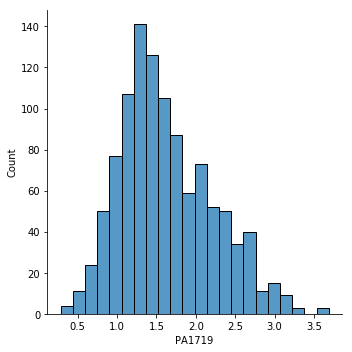

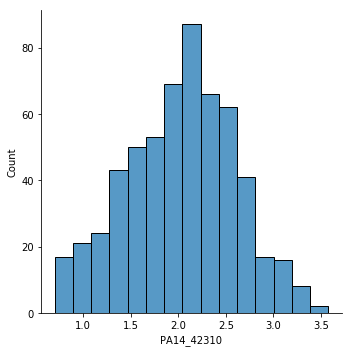

In [34]:
sns.displot(np.log10(pao1_expression[pao1_most_id]))
sns.displot(np.log10(pa14_expression[pa14_most_id]))

### Example of least stable core gene

In [25]:
# Least stable core gene
# pao1_least_id = "PA4685"
# pa14_least_id = "PA14_61980"

pao1_least_id = "PA2458"
pa14_least_id = "PA14_32830"

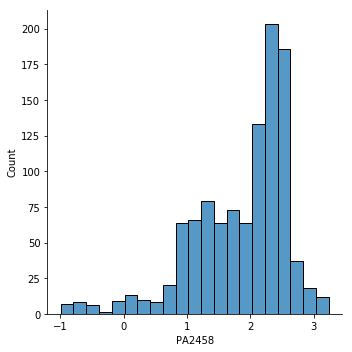

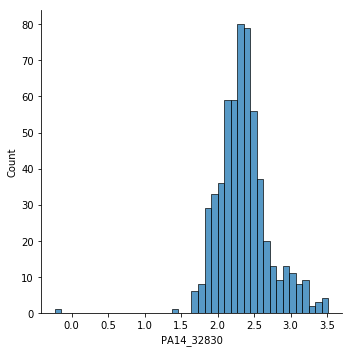

In [26]:
sns.displot(np.log10(pao1_expression[pao1_least_id]))
sns.displot(np.log10(pa14_expression[pa14_least_id]))